# 로지스틱 회귀 - 타이타닉 생존률 예측

## #01. 패키지 준비하기

In [15]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

## #02. 데이터셋 준비하기

In [3]:
origin = read_excel("https://data.hossam.kr/E05/titanic.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## #03. 데이터 전처리

### 결측치 확인

In [4]:
origin.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 결측치 정제

#### 객실번호(`Cabin`)

선실이 부여되지 않은 경우 객실 등급에 따른 차이가 있는지 여부를 확인

In [6]:
df_tmp = origin.filter(['Pclass', 'Cabin']).query('Cabin.isnull()')
df_tmp.fillna(0, inplace=True)
df_tmp.groupby('Pclass').count()

,Cabin
Pclass,
1,40
2,168
3,479


> 객실 번호는 생존 여부에 영향이 없을 것으로 판단하고 변수 자체를 제거 (열단위 제거)

In [7]:
df1 = origin.drop('Cabin', axis=1)
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#### 탑승지

탑승지 데이터가 결측치인 경우는 2건 밖에 되지 않기 때문에 데이터 정제 과정에서 제거 (행단위)

In [8]:
df2 = df1.query('Embarked.notnull()')
df2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


##### 나이를 중앙값으로 대체

나이의 경우 탑승객의 생존 여부에 중요한 영향을 미치는 요인이라고 짐작하고 삭제하지 않기로 결정하였다.

연속형 데이터의 결측치를 대체하기에 가장 적합한 값은 중앙값이므로 중앙값으로 대체한다.

In [10]:
df3 = df2.copy()
df3['Age'].fillna(df3['Age'].median(), inplace=True)
df3.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### 불필요한 필드 제거

#### 탑승객 번호

탑승객 번호는 단순한 일련번호 이므로 생존률에 영향을 주지 않는 값이라고 판단하고 이 값을 인덱스로 설정하였다.

In [11]:
df4 = df3.set_index("PassengerId")
df4.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#### 이름과 티켓번호

생존 여부에 영향을 주지 않는다고 판단하고 제거

In [12]:
df5 = df4.drop(['Name', 'Ticket'], axis=1)
df5.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### 더미변수 처리



In [13]:
cda_df = get_dummies(df5, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True, dtype='int')
cda_df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,1,1,0,1
2,1,38.0,1,0,71.2833,0,0,0,0,0
3,1,26.0,0,0,7.9250,0,1,0,0,1
4,1,35.0,1,0,53.1000,0,0,0,0,1
5,0,35.0,0,0,8.0500,0,1,1,0,1


## #04. 탐색적 데이터 분석

> `E05`의 연습문제 2번으로 진행한바 있으므로 생략

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [16]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [19]:
x = cda_df.drop('Survived', axis=1)
x.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
1,22.0,1,0,7.2500,0,1,1,0,1
2,38.0,1,0,71.2833,0,0,0,0,0
3,26.0,0,0,7.9250,0,1,0,0,1
4,35.0,1,0,53.1000,0,0,0,0,1
5,35.0,0,0,8.0500,0,1,1,0,1


In [18]:
y = cda_df[['Survived']]
y.head()

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


### 데이터 표준화 

> 일단 생략해보기로 함

### 훈련 데이터와 검증 데이터로 분할

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((622, 9), (267, 9), (622, 1), (267, 1))

## #06. 모델 개발

### 모델 정의

In [21]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(9, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 353 (1.38 KB)
Trainable params: 353 (1.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [22]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
20/20 [==============================] - 1s 12ms/step - loss: 0.7238 - acc: 0.6688 - val_loss: 0.6758 - val_acc: 0.7191 - lr: 0.0010
Epoch 2/500
20/20 [==============================] - 0s 3ms/step - loss: 0.6637 - acc: 0.6913 - val_loss: 0.7546 - val_acc: 0.6255 - lr: 0.0010
Epoch 3/500
20/20 [==============================] - 0s 3ms/step - loss: 0.6619 - acc: 0.6785 - val_loss: 0.6519 - val_acc: 0.6742 - lr: 0.0010
Epoch 4/500
20/20 [==============================] - 0s 3ms/step - loss: 0.6532 - acc: 0.6865 - val_loss: 0.6624 - val_acc: 0.6667 - lr: 0.0010
Epoch 5/500
20/20 [==============================] - 0s 6ms/step - loss: 0.6224 - acc: 0.6961 - val_loss: 0.7247 - val_acc: 0.6142 - lr: 0.0010
Epoch 6/500
20/20 [==============================] - 0s 4ms/step - loss: 0.6096 - acc: 0.6865 - val_loss: 0.5994 - val_acc: 0.7228 - lr: 0.0010
Epoch 7/500
20/20 [==============================] - 0s 3ms/step - loss: 0.6031 - acc: 0.6817 - val_loss: 0.5825 - val_acc: 0.7303 - lr

## #07. 학습결과 평가

### 기본적인 머신러닝 학습률 평가

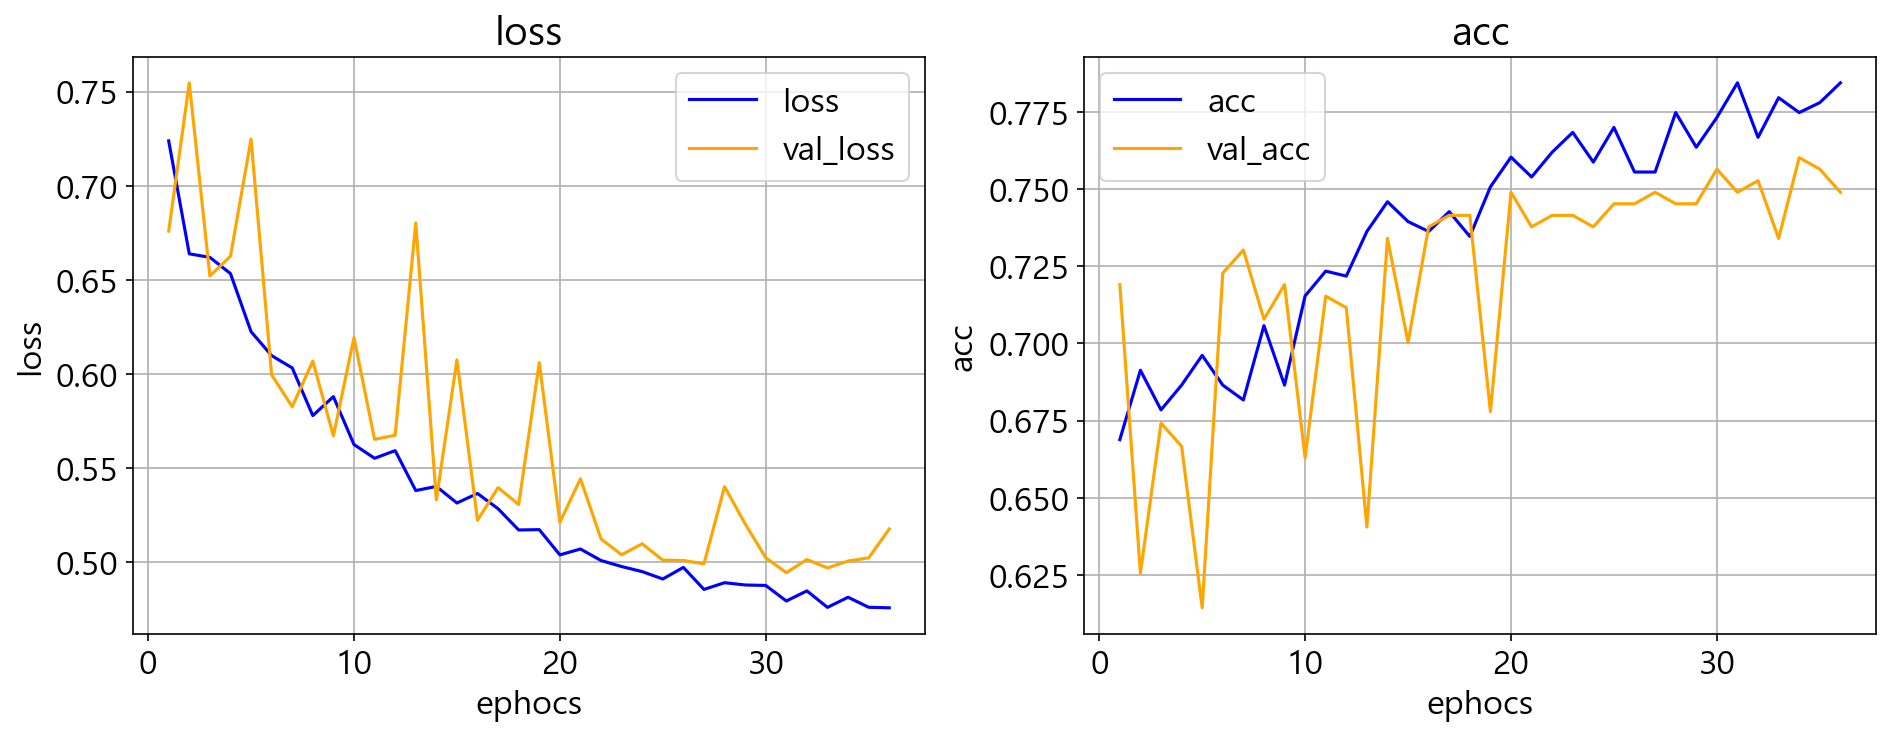

20/20 [==============================] - 0s 2ms/step - loss: 0.4752 - acc: 0.7830
최종 훈련 손실률: 0.475182, 최종 훈련 정확도: 0.782958
9/9 [==============================] - 0s 1ms/step - loss: 0.5175 - acc: 0.7491
최종 검증 손실률: 0.517484, 최종 검증 정확도: 0.749064


In [24]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

### 로지스틱 회귀 결과 검정

> ...

## #08. 학습 결과 적용

### 실제 데이터로 예측해 보기

#### 예측을 위한 데이터 프레임 준비

In [29]:
test_df = DataFrame({
    'dicaprio': [19, 0, 0, 0, 0, 1, 1, 0, 0],  # 영화속 남자 주인공 데이터
    'winslet': [17, 1, 2, 100, 0, 0, 0, 1, 0], # 영화속 여자 주인공 데이터
    'someone': [41, 1, 0, 50, 1, 0, 1, 0, 0]  # 임의의 데이터
}, index=['Age','SibSp','Parch','Fare','Pclass_2','Pclass_3','Sex_male','Embarked_Q','Embarked_S'])
test_df

,dicaprio,winslet,someone
Age,19,17,41
SibSp,0,1,1
Parch,0,2,0
Fare,0,100,50
Pclass_2,0,0,1
Pclass_3,1,0,0
Sex_male,1,0,1
Embarked_Q,0,1,0
Embarked_S,0,0,0


### 결과 예측하기

In [30]:
results = model.predict(test_df.T)
data_count, case_count = results.shape
print("%d개의 임의의 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(results)

1/1 [==============================] - 0s 85ms/step
3개의 임의의 데이터가 1개의 경우의 수를 갖는다.
[[0.12788936]
 [0.7071913 ]
 [0.50494725]]


In [31]:
for i, v in enumerate(results.flatten()):
    print("%s의 생존 확률은 %0.1f%% 입니다." % (test_df.columns[i], v*100))

dicaprio의 생존 확률은 12.8% 입니다.
winslet의 생존 확률은 70.7% 입니다.
someone의 생존 확률은 50.5% 입니다.
